In [1]:
import pandas_datareader as pdr
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
tickers = ['SPY', 'IWM', 'MDY', 'QQQ', 'TLT']

start = dt.datetime(2007, 1, 1)
end = dt.datetime(2020, 1, 1)

data = pdr.get_data_yahoo(tickers, start, end)

data = data['Adj Close']

In [3]:
data['Short'] = 1.0
data = data[['SPY', 'IWM', 'MDY', 'QQQ', 'Short', 'TLT']]

In [4]:
def get_position(roll=60, split=.6):
    log_returns = np.log(data/data.shift())

    log_returns = log_returns[['SPY', 'IWM', 'MDY', 'QQQ', 'Short']].copy()

    rolling_sum = log_returns.copy()

    for ticker in ['SPY', 'IWM', 'MDY', 'QQQ', 'Short']:
        rolling_sum[ticker] = rolling_sum[ticker].rolling(roll).sum()

    rolling_sum = rolling_sum.loc['2010':]
    log_returns = log_returns.loc['2010':]

    position = rolling_sum.apply(lambda x: x == rolling_sum.max(axis=1)).astype(int).shift().to_numpy()
    position[0] = position[1]
    
    step = 20
    for i in range(0, len(position), step):
        position[i:i + step] = position[i]

    position *= split

    position = np.append(position, np.ones((len(position), 2))[:,:1]*(1.-split), axis=1)
    
    return position

In [5]:
def calculate(data):
    cagr = (data.iloc[-1]/data.iloc[0])**(1/10) - 1
    
    rolling_max = data.cummax()
    daily_drawdown = data/rolling_max - 1
    drawdown = daily_drawdown.cummin().iloc[-1]

    log_returns = np.log(data/data.shift())
    volatility = log_returns.std()*(252**.5)
    
    return cagr, drawdown, volatility

def evaluate_position(data, position):
    spy_cagr, spy_drawdown, spy_vol = calculate(data['SPY'])
    
    series = (np.log(data/data.shift())*position).sum(axis=1).cumsum().apply(np.exp)
    
    # print(series.head())
    
    bt_cagr, bt_drawdown, bt_vol = calculate(series)
    
    print(spy_cagr, spy_drawdown, spy_vol)
    print(bt_cagr, bt_drawdown, bt_vol)

In [6]:
evaluate_position(data.loc['2010':], get_position())

0.13244548148388002 -0.1934892785101755 0.14717472883158292
0.08858880009913861 -0.12734213582855347 0.08636724531158187


<IPython.core.display.Javascript object>


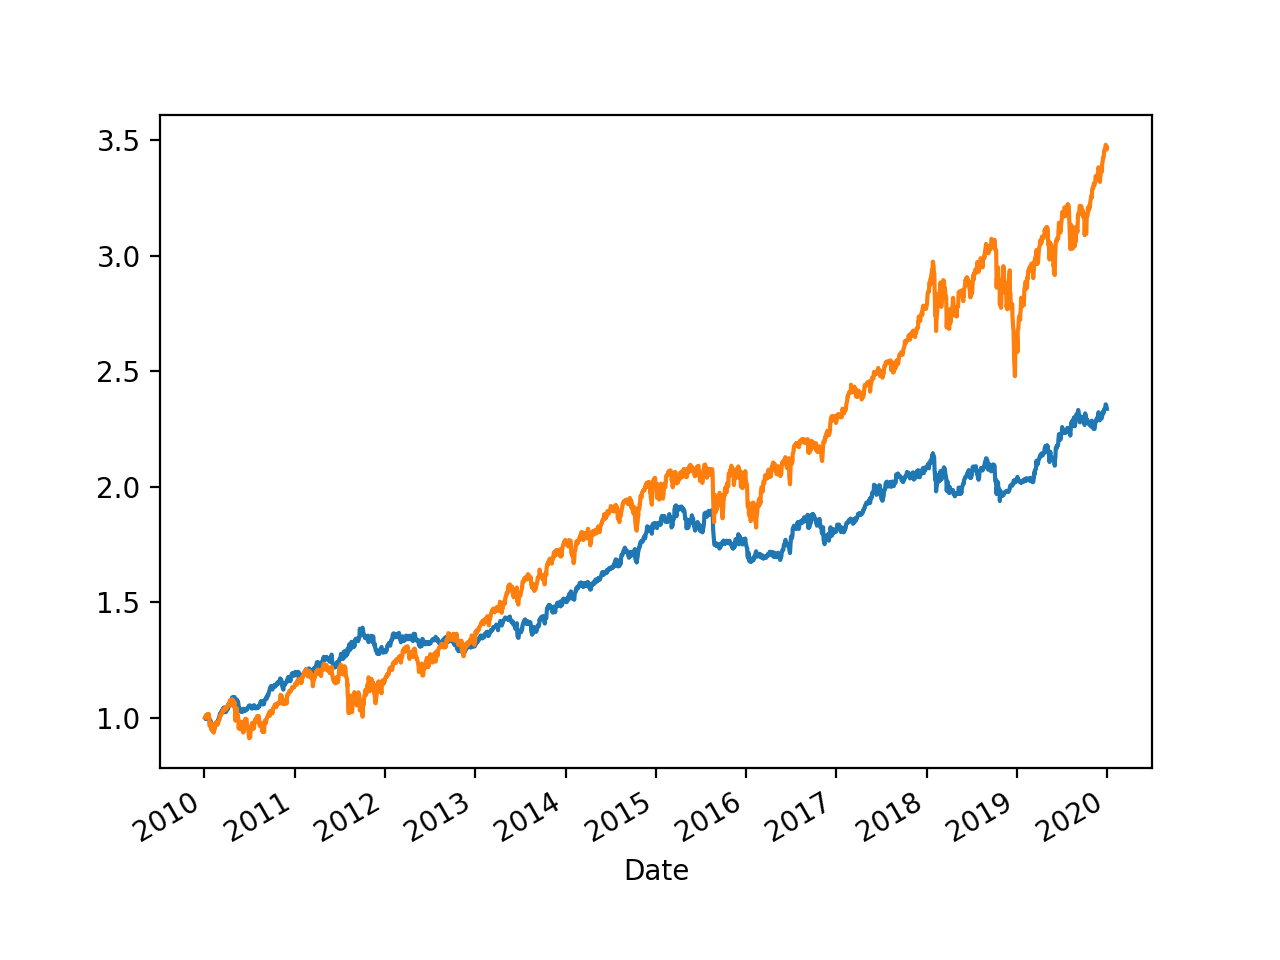

<AxesSubplot:xlabel='Date'>

In [7]:
df = np.log(data.loc['2010':]/data.loc['2010':].shift())*get_position()

fig, ax = plt.subplots()
df.sum(axis=1).cumsum().apply(np.exp).plot(ax=ax)

spy = data['SPY'].loc['2010':]
(spy/spy.iloc[0]).plot(ax=ax)